In [1]:
import pandas, urllib, numpy

In [2]:
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16*(2/3), 9*(2/3)), 
                            'axes.labelsize':20
                           })

In [4]:
# pip install git+https://github.com/Maayanlab/maayanlab-bioinformatics.git
import maayanlab_bioinformatics, maayanlab_bioinformatics.enrichment

# read info

In [5]:
enrichr_library = 'WikiPathways_2024_Human'

In [6]:
inputfile = '/Users/adrian/hub/vigur/003.proteomics/colored_proteins_24.tsv'
df = pandas.read_csv(inputfile, sep='\t')
df.head()

,Uniprot_ID,Uniprot_gene_ID,Gene_name,ENSEMBL,Description,Color_in_plot,log2FC,Adjusted_P_value
0,P30520,PURA2_HUMAN,ADSS2,ENSG00000035687,Adenylosuccinate synthetase isozyme 2,blue,-0.362995,0.022183
1,B7ZBQ3,B7ZBQ3_HUMAN,MED20,ENSG00000124641,Mediator of RNA polymerase II transcription su...,blue,-0.506240,0.045739
2,Q9BYC9,RM20_HUMAN,MRPL20,ENSG00000242485,"39S ribosomal protein L20, mitochondrial",blue,-0.496515,0.003015
3,Q9Y6D5,BIG2_HUMAN,ARFGEF2,ENSG00000124198,Brefeldin A-inhibited guanine nucleotide-excha...,orange,0.183811,0.046504
4,O95218,ZRAB2_HUMAN,ZRANB2,ENSG00000132485,Zinc finger Ran-binding domain-containing prot...,blue,-0.554378,0.043149


In [7]:
sub = df[(df['Color_in_plot'] == 'blue') | (df['Color_in_plot'] == 'red')] # get blue or red. Another notebook for 4 hours.
v = list(sub['Gene_name'].dropna())
genes = list(set(v))
gene_list = [x.strip() for x in genes]
print(len(gene_list))

1644


In [8]:
def get_library(lib_name):
    '''
    Returns a dictionary mapping each term from the input library to 
    its associated geneset. 
    '''
    raw_lib_data = []

    with urllib.request.urlopen('https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName=' + lib_name) as f:
        for line in f.readlines():
            raw_lib_data.append(line.decode("utf-8").split("\t\t"))

    name = []
    gene_list = []
    lib_data = {}

    for i in range(len(raw_lib_data)):
        name += [raw_lib_data[i][0]]
        raw_genes = raw_lib_data[i][1].replace('\t', ' ')
        gene_list += [raw_genes[:-1]]
    
    lib_data = {a[0]:a[1].split(' ') for a in zip(name, gene_list)}
    return lib_data

lib_data = get_library(enrichr_library)

enrich_results = maayanlab_bioinformatics.enrichment.enrich_crisp(genes, lib_data, 21000, True)

res_df = pandas.DataFrame(
    [ [
        term, 
        res.pvalue, 
        res.odds_ratio,
        res.n_overlap,

    ] for (term, res) in enrich_results ], 
    columns=['term', 'pvalue', 'odds_ratio', 'n_overlap']
)
res_df

,term,pvalue,odds_ratio,n_overlap
0,TCA Cycle And Deficiency Of Pyruvate Dehydroge...,0.039089,3.629081,4
1,Mammary Gland Development Pathway Embryonic De...,0.359905,1.682791,2
2,Initiation Of Transcription And Translation El...,0.111805,2.105814,5
3,Hypothesized Pathways In Pathogenesis Of Cardi...,0.141736,2.143459,4
4,TGF Beta In Thyroid Cells For Epithelial Mesen...,0.047238,3.369686,4
...,...,...,...,...
706,Cori Cycle WP1946,0.010566,4.539119,5
707,Cell Cycle WP179,0.002697,2.207095,19
708,Autophagy WP4923,0.002140,4.110343,8
709,Apoptosis WP254,0.501949,1.056858,7


In [9]:
# checked done, all good
container = []
for pathway in res_df['term']:
    
    overlap_genes = []
    for query in lib_data[pathway]:
        if query in genes:
            overlap_genes.append(query)
    overlap_genes_string = ', '.join(overlap_genes)
    container.append(overlap_genes_string)
    
res_df.loc[:, 'overlap_genes'] = container
res_df

,term,pvalue,odds_ratio,n_overlap,overlap_genes
0,TCA Cycle And Deficiency Of Pyruvate Dehydroge...,0.039089,3.629081,4,"FH, DLST, CS, DLAT"
1,Mammary Gland Development Pathway Embryonic De...,0.359905,1.682791,2,"ITGB1, CCND1"
2,Initiation Of Transcription And Translation El...,0.111805,2.105814,5,"SUPT5H, HDAC1, HDAC2, NELFCD, NELFB"
3,Hypothesized Pathways In Pathogenesis Of Cardi...,0.141736,2.143459,4,"SMAD3, SMAD2, ENG, CCN2"
4,TGF Beta In Thyroid Cells For Epithelial Mesen...,0.047238,3.369686,4,"SMAD3, SMAD2, FN1, VIM"
...,...,...,...,...,...
706,Cori Cycle WP1946,0.010566,4.539119,5,"TPI1, PGAM1, ALDOA, GAPDH, PFKP"
707,Cell Cycle WP179,0.002697,2.207095,19,"CCND1, SMAD3, SMAD2, PRKDC, SMC3, CCNB1, CDC7,..."
708,Autophagy WP4923,0.002140,4.110343,8,"ATG3, UVRAG, PRKAB2, AKT1S1, PIK3R4, PRKAA1, M..."
709,Apoptosis WP254,0.501949,1.056858,7,"JUN, BAD, DIABLO, CASP10, CASP3, FADD, IKBKG"


# multiple test correction

In [10]:
results = statsmodels.stats.multitest.multipletests(res_df['pvalue'], alpha=0.05, method='fdr_bh')
res_df['adjusted'] = results[1]

# plot

(514, 6)
(197, 6)


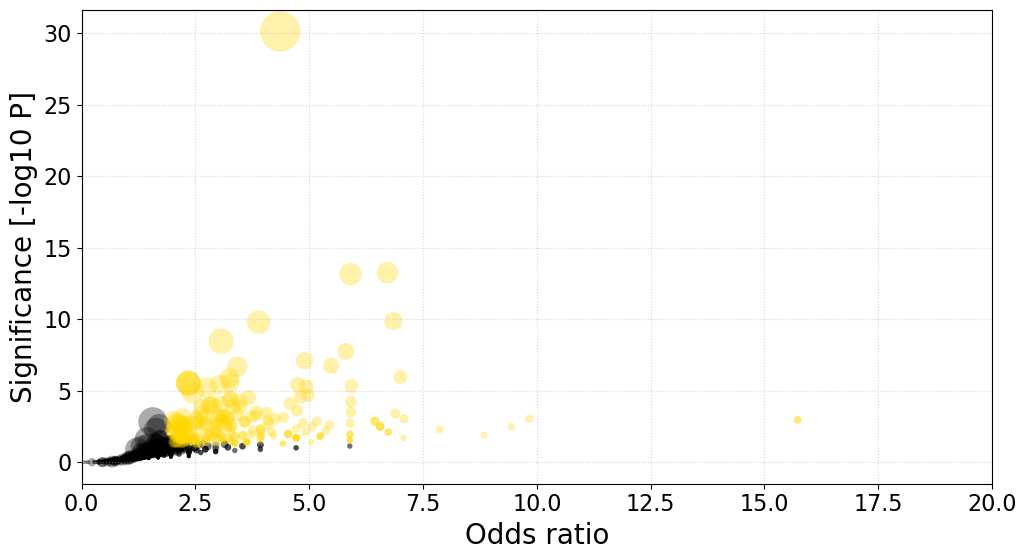

In [11]:
a = res_df[(res_df['pvalue'] > 0.05) | (res_df['odds_ratio'] < 2)]
print(a.shape)
x = a['odds_ratio']
y = -numpy.log10(a['pvalue'])
names = a['term']
s = a['n_overlap']
matplotlib.pyplot.scatter(x, y, s*7.5, alpha=1/3, edgecolors='none', color='black')

b = res_df[(res_df['pvalue'] < 0.05) & (res_df['odds_ratio'] > 2)]
print(b.shape)
x = b['odds_ratio']
y = -numpy.log10(b['pvalue'])
names = b['term']
s = b['n_overlap']
matplotlib.pyplot.scatter(x, y, s*7.5, alpha=1/3, edgecolors='none', color='gold')

matplotlib.pyplot.xlim(0, 20)

matplotlib.pyplot.xlabel('Odds ratio')
matplotlib.pyplot.ylabel('Significance [-log10 P]')
matplotlib.pyplot.grid(ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [25]:
a = res_df[(res_df['adjusted'] > 0.05) | (res_df['odds_ratio'] < 2)]
print(a.shape)
x = a['odds_ratio']
y = -numpy.log10(a['adjusted'])
s = a['n_overlap']
matplotlib.pyplot.scatter(x, y, s*8, alpha=1/12, edgecolors='none', color='black')

b = res_df[(res_df['adjusted'] < 0.05) & (res_df['odds_ratio'] > 2)]
print(b.shape)
x = b['odds_ratio']
y = -numpy.log10(b['adjusted'])
s = b['n_overlap']
sc = matplotlib.pyplot.scatter(x, y, s*8, alpha=0.8, edgecolors='none', color='gold')

x = list(b['odds_ratio'])
y = list(-numpy.log10(b['adjusted']))
prez = list(b['term'].values)
z = [element.split()[-1] for element in prez]
w = list(b['overlap_genes'].values)
importance = [numpy.sqrt(x[i]**2 + y[i]**2) for i in range(len(x))]
b.loc[:, 'importance'] = importance
c = b.sort_values('importance', ascending=False)

threshold = 6.8 # seven
com = c[c['importance'] > threshold]
count = 0
for index, row in com.iterrows():
    x = 0; y = 0
    x = row['odds_ratio']
    y = -numpy.log10(row['adjusted'])
    label = row['term'].split()[-1]
    matplotlib.pyplot.text(x, y, label, fontsize=12)
    count = count + 1
    print('{}\t{}\t{}\t{:.1f}\t{}\t{}'.format(count, x, y, row['importance'], row['term'], row['n_overlap'])

matplotlib.pyplot.legend(*sc.legend_elements("sizes", num=4))
#matplotlib.pyplot.xlim(0, 17)
matplotlib.pyplot.xlabel('Odds ratio')
matplotlib.pyplot.ylabel('Significance [-log10 P]')
matplotlib.pyplot.grid(ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()

matplotlib.pyplot.show()
#matplotlib.pyplot.savefig('functions.24.svg')

SyntaxError: '(' was never closed (793329656.py, line 34)

In [13]:
c.head()

,term,pvalue,odds_ratio,n_overlap,overlap_genes,adjusted,importance
558,VEGFA VEGFR2 Signaling WP3888,7.838456e-31,4.362818,112,"ACOT9, DKK1, RPL27, ARPC5L, EWSR1, PRKAA1, FAM...",5.573142e-28,27.600892
580,Cellular Proteostasis WP4918,1.080203e-03,15.734146,4,"VBP1, PFDN1, PFDN2, PFDN6",1.259056e-02,15.848444
497,Fluoroacetic Acid Toxicity WP4966,1.080203e-03,15.734146,4,"ACO2, ACSS2, ALDH9A1, CS",1.259056e-02,15.848444
456,Cytoplasmic Ribosomal Proteins WP477,5.624543e-14,6.721170,32,"RPS8, RPL24, RPS6, RPL37A, RPL27, RPL13, RPL12...",1.713689e-11,12.691822
112,Electron Transport Chain OXPHOS System In Mito...,7.230757e-14,5.908446,35,"SDHC, UQCRQ, UQCR10, UQCR11, ATP5IF1, NDUFV2, ...",1.713689e-11,12.280796


In [14]:
print(c.shape)
c.drop('pvalue', axis='columns', inplace=True)
d = c.iloc[:, [0, 5, 4, 1, 2, 3]]
d.rename(columns={"term": "Term", 
                  "importance": "Priority", 
                  'adjusted':'Adjusted P', 
                  'odds_ratio':'Odds ratio',
                 'n_overlap':'N overlap',
                 'overlap_genes':'Overlap genes'}, inplace=True)
d.set_index('Term', inplace=True)
d.head()

(117, 7)


,Priority,Adjusted P,Odds ratio,N overlap,Overlap genes
Term,,,,,
VEGFA VEGFR2 Signaling WP3888,27.600892,5.573142e-28,4.362818,112,"ACOT9, DKK1, RPL27, ARPC5L, EWSR1, PRKAA1, FAM..."
Cellular Proteostasis WP4918,15.848444,1.259056e-02,15.734146,4,"VBP1, PFDN1, PFDN2, PFDN6"
Fluoroacetic Acid Toxicity WP4966,15.848444,1.259056e-02,15.734146,4,"ACO2, ACSS2, ALDH9A1, CS"
Cytoplasmic Ribosomal Proteins WP477,12.691822,1.713689e-11,6.721170,32,"RPS8, RPL24, RPS6, RPL37A, RPL27, RPL13, RPL12..."
Electron Transport Chain OXPHOS System In Mitochondria WP111,12.280796,1.713689e-11,5.908446,35,"SDHC, UQCRQ, UQCR10, UQCR11, ATP5IF1, NDUFV2, ..."


In [15]:
d.to_csv('functional_analysis.24.tsv', sep='\t')